# GPU part

In [ ]:
# https://ssharoff.github.io/kelly/dfly/
!xz -d /content/vikidia-fr.ol.xz

In [7]:
lang = 'fr'

In [ ]:
import re
import torch
from transformers import pipeline
from collections import Counter

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", tokenizer="dslim/bert-base-NER", device=device)

def get_main_entity(text):
    try:
        results = ner_pipeline(text)
        # Агрегация результатов
        entity_counts = Counter(result["entity"] for result in results)
        # Определение самой частой категории
        dominant_entity = entity_counts.most_common(1)[0][0]
        return dominant_entity.split("-", 1)[-1].strip()
    except:
        return 'O'


def extract_articles(file_path):
    articles = []
    with open(file_path, "rt") as file:
        for line in file:
            # Парсим строку для извлечения заголовка и текста статьи
            match = re.match(r'__id__wiki/(.+?)\t<h> (.+?) <p> (.+?) </text>', line)
            if match:
                article_id = match.group(1)
                title = match.group(2)
                text = match.group(3)
                #articles.append({'id': article_id, 'title': title, 'text': text.replace('<p>', '')})
                article = text.replace('<p>', '')

                articles.append({'title': title, 'entity': get_main_entity(article), 'text': article})
    return articles


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
file_path = f'/content/vikidia-{lang}.ol'

articles = extract_articles(file_path)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [11]:
import pandas as pd

res = pd.DataFrame(articles)
res.to_csv(f'vikidia_{lang}.csv', index=False)

NameError: name 'articles' is not defined

# CPU part

In [1]:
import pandas as pd
lang = 'fr'
res = pd.read_csv(f'./vikidia_{lang}.csv').reset_index(drop=True)

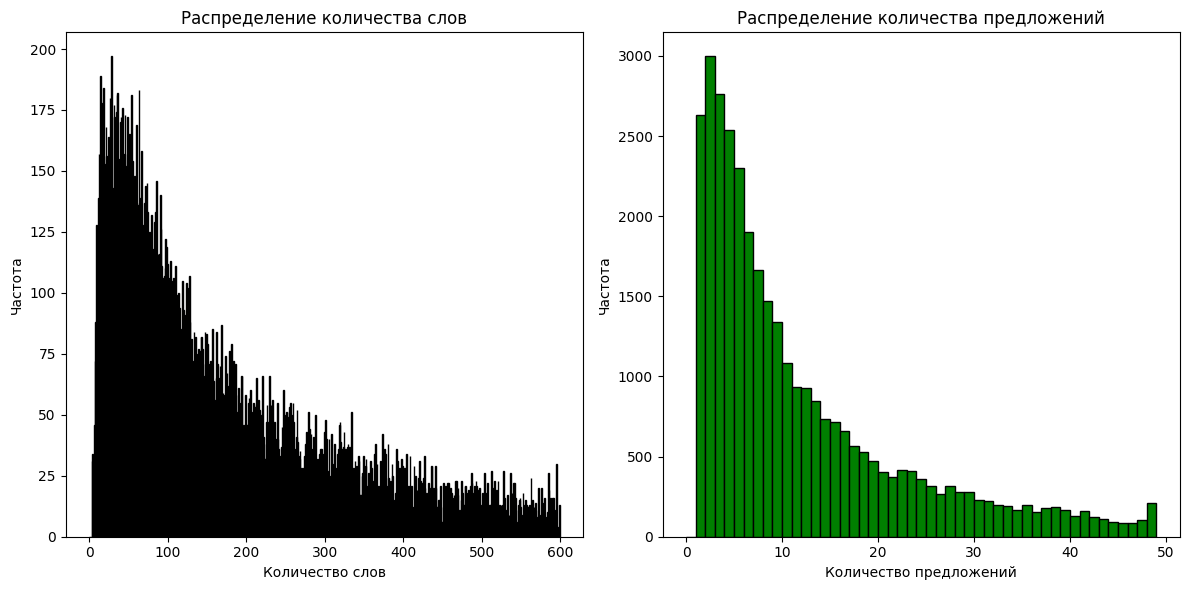

In [2]:
import matplotlib.pyplot as plt

# Вычисляем количество слов и предложений для каждого текста
word_counts = [len(text.split()) for text in res['text']]
sentence_counts = [len(text.split('. ')) for text in res['text']]

# Построение распределения количества слов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(word_counts, bins=range(0, 600), color='blue', edgecolor='black')
plt.title('Распределение количества слов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')

# Построение распределения количества предложений
plt.subplot(1, 2, 2)
plt.hist(sentence_counts, bins=range(0, 50), color='green', edgecolor='black')
plt.title('Распределение количества предложений')
plt.xlabel('Количество предложений')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


In [3]:
def calculate_average_lengths(df):
    total_sentences = 0
    total_words = 0

    for text in df['text']:
        sentences = text.split('.')
        words = text.split(' ')

        total_sentences += len(sentences)
        total_words += len(words)

    average_sentence_length = total_sentences / len(df)
    average_word_length = total_words / len(df)

    return average_sentence_length, average_word_length

calculate_average_lengths(res)

(19.55490330544507, 346.5976957893293)

In [4]:
res['entity'].value_counts()

ORG     10706
PER      9560
LOC      6727
O        6522
MISC     2940
Name: entity, dtype: int64

In [5]:
!pip install Wikipedia-API

In [6]:
import wikipediaapi

wiki_wiki = wikipediaapi.Wikipedia('bert_research', lang)

def get_article_from_wiki(title):
    page = wiki_wiki.page(title)

    if not page.exists():
        return None

    text = page.text
    text = " ".join(text.split()[:100])
    text = text.replace('\n', '')
    text = text.replace('\\', '')
    text = text.replace(';', ',')

    return text

In [7]:
res = res.rename(columns = {'text': 'Vikidia'})

res['Wikipedia'] = res['title'].apply(get_article_from_wiki)

In [8]:
res.to_csv(f'dataset_{lang}.csv', index=False, sep=';')

In [9]:
res.head()

,title,entity,Vikidia,Wikipedia
0,Article de la semaine,PER,Le flamant rose (nom scientifique : Phoenicopt...,None
1,Camargue,ORG,La Camargue est une région naturelle du Sud-Es...,La Camargue (prononcé /ka.maʁg/ en français st...
2,Nom scientifique,PER,"Carl von Linné, inventeur de la nomenclature b...","En sciences naturelles, et plus précisément en..."
3,Oiseau,ORG,Un oiseau est un animal appartenant à la class...,Les Oiseaux (Aves) sont une classe de Vertébré...
4,Échassier,O,L'aigrette est un oiseau échassier : elle util...,Les échassiers forment un groupe d'oiseaux rec...
